In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from tabulate import tabulate
%matplotlib inline  

Intro text here

In [7]:
df = pd.read_csv("dob.csv", index_col=0)
df = df.sort_values('y')
df = df.drop(columns="geometry")
df.head().to_markdown()

'|     |            x |            y |   dob |\n|----:|-------------:|-------------:|------:|\n| 111 | -5.4247e+06  | -4.38456e+06 |   206 |\n| 110 | -5.42516e+06 | -4.38456e+06 |   206 |\n| 109 | -5.42238e+06 | -4.38317e+06 |   206 |\n| 108 | -5.42284e+06 | -4.38317e+06 |   206 |\n| 107 | -5.42794e+06 | -4.38317e+06 |   199 |'

So as expected the data is essentially a collection of around 230-thousand x and y p in a projected sinusodial projection (the MODIS projection) and a day of burn (DOB) for each fire. 

## geopandas

geopandas is a python package that provides a geosptail extensions to pandas. So that dataframes can store geographic data such as points and polygons. Given our spatial data is point data with x and y coordinates it's simple to convert the `df` into a `GeoDataFrame`:

In [8]:
import geopandas
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y), 
                            crs="+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
gdf.head().to_markdown()

'|     |            x |            y |   dob | geometry                                      |\n|----:|-------------:|-------------:|------:|:----------------------------------------------|\n| 111 | -5.4247e+06  | -4.38456e+06 |   206 | POINT (-5424696.941458113 -4384559.892867883) |\n| 110 | -5.42516e+06 | -4.38456e+06 |   206 | POINT (-5425160.25417464 -4384559.892867883)  |\n| 109 | -5.42238e+06 | -4.38317e+06 |   206 | POINT (-5422380.377875471 -4383169.954718296) |\n| 108 | -5.42284e+06 | -4.38317e+06 |   206 | POINT (-5422843.690592 -4383169.954718296)    |\n| 107 | -5.42794e+06 | -4.38317e+06 |   199 | POINT (-5427940.130473807 -4383169.954718296) |'

So geopandas has taken the `x` and `y` fields and made simple point geometries. We don't need the `x` and `y` fields anymore so let's drop those and then use geopandas to plot the points:

In [9]:
gdf = gdf.drop(columns=['x', 'y'])
gdf.tail().to_markdown()

'|    |   dob | geometry                                     |\n|---:|------:|:---------------------------------------------|\n|  6 |   197 | POINT (-5506239.979567026 6673324.712505849) |\n|  5 |   197 | POINT (-5506703.292283554 6673324.712505849) |\n|  4 |   205 | POINT (-5507166.605000081 6673324.712505849) |\n|  1 |   191 | POINT (-5510409.794015776 6673324.712505849) |\n|  0 |   205 | POINT (-5504850.041417442 6674714.650655435) |'

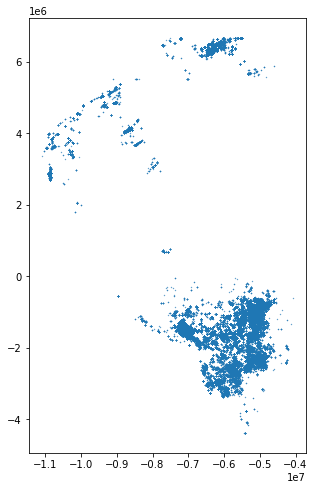

In [17]:
gdf.plot(markersize=.1, figsize=(8, 8))


So that doesn't really make a lot of sense yet although geopandas has correctly plotted a marker for each point using the `geometry` column of the dataframe.  Let's make a more useful plot of the data:

(-11457769.810999077,
 -3715258.3425566605,
 -4937523.620044048,
 7227678.377831601)

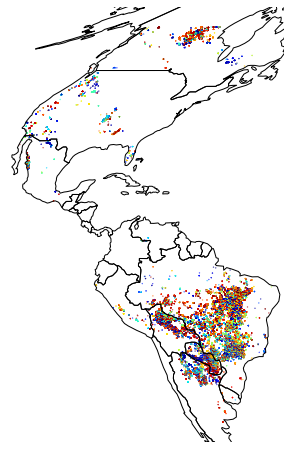

In [19]:
ax = gdf.plot(markersize=.1, figsize=(12, 8), column='dob', cmap='jet')
plt.autoscale(False)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.to_crs(gdf.crs).plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

So geopandas can do some nice things like on-the-fly reprojection -- we've taken the `world` geodataframe and reprojected it from WGS84 to the MODIS sinusodial projection that the fire data is in with the coordinate reference systems.  `world.to_crs(gdf.crs)` 

### r-trees in geopandas

The r-tree is built when the attribute  `gdf.sindex` is accessed:


In [20]:
r_tree = gdf.sindex
print(r_tree)

rtree.index.Index(bounds=[-11105837.471524423, -4384559.892867883, -4067190.682031316, 6674714.650655435], size=226719)


The r-tree has a leaves method which shows the spatial partitioning structure of each leaf of the r-tree:


In [21]:
for leaf in r_tree.leaves()[:2]:
    idxs, indices, bbox = leaf
    print(f'-> points in box {idxs}: ',  indices, '\n bounding box: ', bbox, '\n')
    
print(f"number of leaves: {len(r_tree.leaves())}")

-> points in box 6:  [182654, 182656, 182665, 182663, 182659, 182664, 182655, 182657, 182660, 182652, 182653, 182675, 182677, 182671, 182670, 182674, 182680, 182678, 182673, 182672, 182669, 182668, 182679, 182676, 182686, 182681, 182684, 182687, 182690, 182688, 182685, 182682, 182689, 182683, 182692, 182696, 182693, 182699, 182695, 182697, 182694, 182691, 182698, 182703, 182702, 182706, 182704, 182707, 182701, 182705, 182700, 182710, 182711, 182709, 182708, 182712, 182713, 182714, 182715, 182716, 182718, 182717, 182719, 182721, 182720, 182722, 182728, 182725, 182724, 182729] 
 bounding box:  [-10882520.74215797, 2750455.9416639777, -10852868.728300184, 2759722.1959945355] 

-> points in box 7:  [182730, 182723, 182727, 182726, 182741, 182733, 182731, 182740, 182739, 182742, 182734, 182732, 182735, 182738, 182736, 182737, 182743, 182756, 182744, 182754, 182746, 182749, 182750, 182747, 182748, 182753, 182752, 182751, 182755, 182745, 182757, 182758, 182760, 182759, 182762, 182761, 182763,

Plot the first 200 bounding boxes:

(-11457769.810999077,
 -3715258.3425566605,
 -4937523.620044048,
 7227678.377831601)

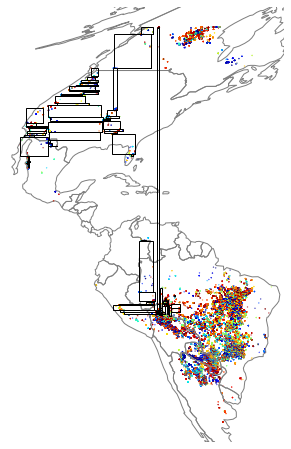

In [22]:
import shapely.geometry
from descartes import PolygonPatch

ax = gdf.plot(markersize=.1, figsize=(12, 8), column='dob', cmap='jet')
plt.autoscale(False)

for leaf in r_tree.leaves()[:200]:
    idxs, indices, bbox = leaf
    r_box = shapely.geometry.box(*bbox)
    box_patch = PolygonPatch(r_box, fc='None', ec='k')
    ax.add_patch(box_patch)
    
world.to_crs(gdf.crs).plot(ax=ax, color='none', edgecolor='grey')
ax.axis('off')

So that's just the first 1000 bounding boxes the r-tree spatial index but some features about it can already be determined. MORE>>>

### generating a grid

To make a regular rectangular mesh for the binned data we can loop over the extent of the data and use shapely to produce each individual grid cell as a geometric polygon:

In [23]:
xmin, ymin, xmax, ymax= gdf.total_bounds

n_cells=30
cell_size = (xmax-xmin)/n_cells

crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)


Plotting the grid over the data:

(-11457769.810999077,
 -3715258.3425566605,
 -4937523.620044048,
 7227678.377831601)

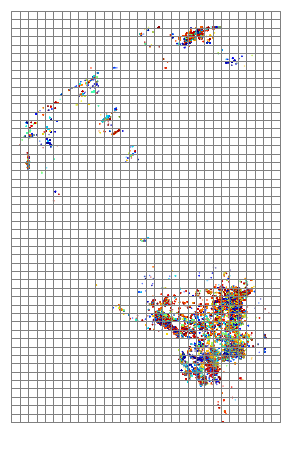

In [24]:
ax = gdf.plot(markersize=.1, figsize=(12, 8), column='dob', cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

# geopandas sjoin and dissolve

TEXT about this

In [25]:
merged = geopandas.sjoin(gdf, cell, how='left', op='within')
# make a simple count variable that we can sum
merged['n_fires']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")

In [26]:
cell.loc[dissolve.index, 'n_fires']=dissolve.n_fires.values

(-11457769.81099908,
 -3715258.3425566335,
 -4947651.636027331,
 7440366.713480534)

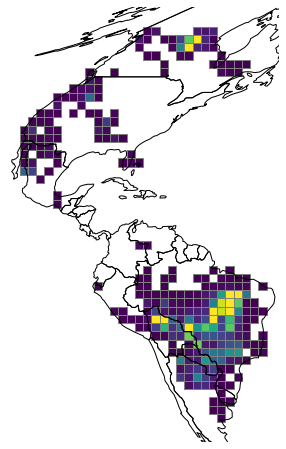

In [27]:
ax = cell.plot(column='n_fires', figsize=(12, 8), cmap='viridis', vmax=5000, edgecolor="grey")
plt.autoscale(False)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.to_crs(cell.crs).plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

It's then pretty straightforward to convert this into an actual array of data:

# why bother with the xxx?

Seperating the binning of the data and the real gridded data as an array seems a bit artificial. We could for example just have used the grid extent 